In [21]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser

In [31]:
PROTON_MASS = 1.00727647
ADD_C_CYSTEINE_DA = 57.021464

In [30]:
# calculate the monoisotopic mass    
def calculate_monoisotopic_mass_from_mz(monoisotopic_mz, charge):
    monoisotopic_mass = (monoisotopic_mz * charge) - (PROTON_MASS * charge)
    return monoisotopic_mass

In [2]:
experiment_name = 'P3856'
run_name = 'P3856_YHE211_1_Slot1-1_1_5104'
precursor_definition_method = 'pasef'
experiment_base_dir = '/media/big-ssd/experiments'

In [3]:
EXPERIMENT_DIR = "{}/{}".format(experiment_base_dir, experiment_name)
MQ_PERCOLATOR_OUTPUT_DIR = '{}/percolator-output-pasef-maxquant'.format(EXPERIMENT_DIR)

In [4]:
MAXIMUM_Q_VALUE = 0.01

In [5]:
# load the percolator output
MQ_PERCOLATOR_OUTPUT_FILE_NAME = "{}/{}.percolator.target.psms.txt".format(MQ_PERCOLATOR_OUTPUT_DIR, experiment_name)
mq_psms_df = pd.read_csv(MQ_PERCOLATOR_OUTPUT_FILE_NAME, sep='\t')
mq_psms_df.rename(columns={'scan': 'mq_index'}, inplace=True)
# remove the poor quality identifications
mq_psms_df = mq_psms_df[mq_psms_df['peptide mass'] > 0]

In [27]:
mq_psms_df.columns

Index(['file_idx', 'mq_index', 'charge', 'spectrum precursor m/z',
       'spectrum neutral mass', 'peptide mass', 'percolator score',
       'percolator q-value', 'percolator PEP', 'total matches/spectrum',
       'sequence', 'protein id', 'flanking aa'],
      dtype='object')

In [32]:
# add the mass of cysteine carbamidomethylation to the theoretical peptide mass from percolator, for the fixed modification of carbamidomethyl
mq_psms_df['observed_monoisotopic_mass'] = calculate_monoisotopic_mass_from_mz(mq_psms_df['spectrum precursor m/z'], mq_psms_df.charge)
mq_psms_df['theoretical_peptide_mass'] = mq_psms_df['peptide mass'] + (mq_psms_df.sequence.str.count('C') * ADD_C_CYSTEINE_DA)
mq_psms_df['mass_accuracy_ppm'] = (mq_psms_df['observed_monoisotopic_mass'] - mq_psms_df['theoretical_peptide_mass']) / mq_psms_df['theoretical_peptide_mass'] * 10**6
mq_psms_df['mass_error'] = mq_psms_df['observed_monoisotopic_mass'] - mq_psms_df['theoretical_peptide_mass']


In [33]:
mq_sequences_l = []
for group_name,group_df in mq_psms_df.groupby(['sequence','charge'], as_index=False):
    if group_df['percolator q-value'].min() <= MAXIMUM_Q_VALUE:
        mq_index = group_df.loc[group_df['percolator q-value'].idxmin()].mq_index
        score = group_df['percolator score'].max()
        mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
        mq_sequences_l.append({'sequence_key':'{}-{}'.format(group_name[0], group_name[1]), 'mq_index':mq_index, 'score':score, 'mass_accuracy_ppm':mass_accuracy_ppm})
mq_sequences_df = pd.DataFrame(mq_sequences_l)

In [34]:
mq_sequences_df.sample(n=3)

,sequence_key,mq_index,score,mass_accuracy_ppm
6554,VDPSLMEDSDDGPSLPTK-2,14142,0.523464,4.126000
108,AELRPLQFK-2,486,0.523658,-1.047523
3067,IINDNLVTIGSSLDHCK-2,14077,0.946811,-2.274520


In [8]:
# load my identifications
BASE_DIR = '{}/P3856-results-cs-true-fmdw-true-2021-05-01-14-59-47'.format(expanduser('~'))
IDENTS_DIR = '{}/identifications-{}'.format(BASE_DIR, precursor_definition_method)
IDENTS_NAME = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTS_DIR, experiment_name, precursor_definition_method)

In [9]:
identifications_before_unique_df = pd.read_pickle(IDENTS_NAME)['identifications_df']

In [35]:
sequences_l = []
for group_name,group_df in identifications_before_unique_df.groupby(['sequence','charge'], as_index=False):
    if group_df['percolator q-value'].min() <= MAXIMUM_Q_VALUE:
        feature_id = int(group_df.loc[group_df['percolator q-value'].idxmin()].feature_id)
        score = group_df['percolator score'].max()
        mass_accuracy_ppm = group_df.mass_accuracy_ppm.min()
        sequences_l.append({'sequence_key':'{}-{}'.format(group_name[0], group_name[1]), 'feature_id':feature_id, 'score':score, 'mass_accuracy_ppm':mass_accuracy_ppm})
sequences_df = pd.DataFrame(sequences_l)

In [36]:
sequences_df.sample(n=3)

,sequence_key,feature_id,score,mass_accuracy_ppm
6127,SNLAYDIVQLPTGLTGIK-2,4164601,1.175045,0.163680
2740,HGADCLEANQDVDSPIWTPSK-2,1842101,0.483335,-0.228092
1540,ELQSLLGK-1,1472801,0.068124,-0.456279


In [37]:
common_df = pd.merge(mq_sequences_df, sequences_df, how='inner', left_on=['sequence_key'], right_on=['sequence_key'], suffixes=['_mq','_tfde'])


In [38]:
common_df.columns

Index(['sequence_key', 'mq_index', 'score_mq', 'mass_accuracy_ppm_mq',
       'feature_id', 'score_tfde', 'mass_accuracy_ppm_tfde'],
      dtype='object')

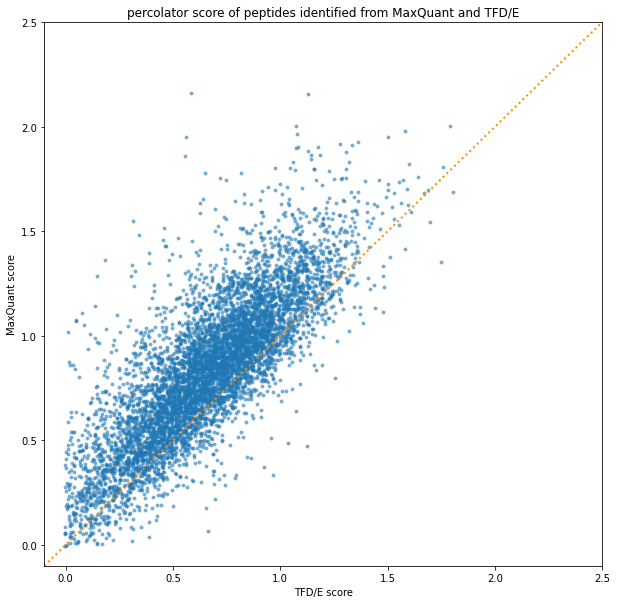

In [39]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('percolator score of peptides identified from MaxQuant and TFD/E')

ax.scatter(common_df.score_tfde, common_df.score_mq, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

plt.xlim((-0.1,2.5))
plt.ylim((-0.1,2.5))

plt.xlabel('TFD/E score')
plt.ylabel('MaxQuant score')

plt.show()

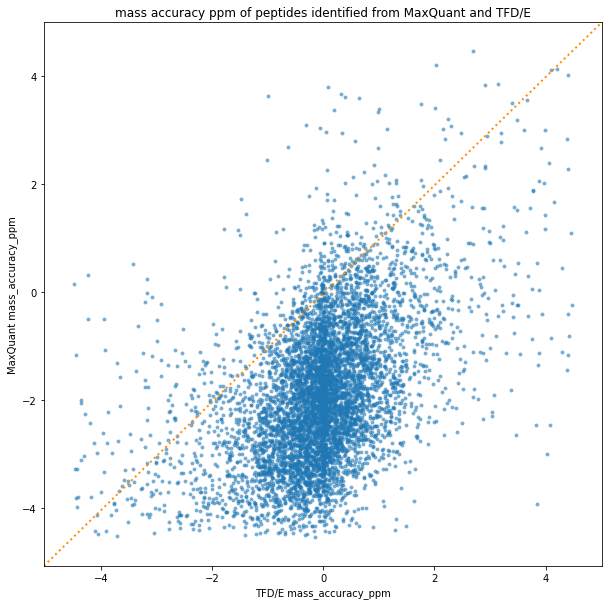

In [42]:
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(10)

plt.margins(0.06)
plt.title('mass accuracy ppm of peptides identified from MaxQuant and TFD/E')

ax.scatter(common_df.mass_accuracy_ppm_tfde, common_df.mass_accuracy_ppm_mq, marker='o', lw=0, s=15, alpha=0.6)

ax.plot([0, 1], [0, 1], transform=ax.transAxes, linestyle=':', linewidth=2, color='darkorange')

# plt.xlim((-0.1,2.5))
# plt.ylim((-0.1,2.5))

plt.xlabel('TFD/E mass_accuracy_ppm')
plt.ylabel('MaxQuant mass_accuracy_ppm')

plt.show()